<a href="https://colab.research.google.com/github/tramyynt/Delivery-Hiring/blob/main/Delivery_Hiring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from datetime import date, datetime
import numpy as np
import calendar

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px

import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,cross_val_score

from sklearn.metrics import r2_score
import sklearn.metrics as metrics

In [ ]:
order = pd.read_csv('/content/drive/MyDrive/Deliveroo Hiring - Test for Machine Learning Engineering/orders.csv.gz (Unzipped Files)/orders.csv')
restaurant = pd.read_csv('/content/drive/MyDrive/Deliveroo Hiring - Test for Machine Learning Engineering/restaurants.csv.gz (Unzipped Files)/restaurants.csv')

In [ ]:
order.head(5)

,order_acknowledged_at,order_ready_at,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds
0,2015-06-01 12:28:28.952789+01:00,2015-06-01 14:12:09.474896+01:00,59.90,1326,2,6220
1,2015-06-06 17:06:24.434807+01:00,2015-06-06 17:16:27.520253+01:00,24.00,1326,8,603
2,2015-06-08 14:56:15.503204+01:00,2015-06-08 15:03:39.397496+01:00,15.25,1326,3,443
3,2015-06-12 15:12:20.497925+01:00,2015-06-12 15:23:30.064683+01:00,28.05,1326,8,669
4,2015-06-01 13:07:10.794050+01:00,2015-06-01 14:02:25.104517+01:00,56.30,255,7,3314


In [ ]:
order.describe()

,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds
count,32394.000000,32394.000000,32394.000000,32394.000000
mean,26.547303,1290.555535,4.025715,1299.993857
std,19.263851,960.295504,2.392063,4404.573191
min,0.500000,3.000000,1.000000,0.000000
25%,16.700000,408.000000,3.000000,518.000000
50%,21.400000,1160.000000,3.000000,820.000000
75%,30.250000,2117.000000,5.000000,1227.000000
max,711.000000,3622.000000,38.000000,255499.000000


In [ ]:
order.isnull().sum()

order_acknowledged_at    0
order_ready_at           0
order_value_gbp          0
restaurant_id            0
number_of_items          0
prep_time_seconds        0
dtype: int64

In [ ]:
restaurant.isnull().sum()

restaurant_id    0
country          0
city             0
type_of_food     0
dtype: int64

In [ ]:
restaurant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1697 entries, 0 to 1696
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   restaurant_id  1697 non-null   int64 
 1   country        1697 non-null   object
 2   city           1697 non-null   object
 3   type_of_food   1697 non-null   object
dtypes: int64(1), object(3)
memory usage: 53.2+ KB


In [ ]:
print(order.isna().sum().sum())
print(restaurant.isna().sum().sum())

0
0


### Exploratory Data Analysis

Order

Split date time

In [ ]:
order['order_acknowledged_at']=pd.to_datetime(order['order_acknowledged_at'], utc=True,format='%Y-%m-%d %H:%M:%S')
order['ord_ack_date']= order['order_acknowledged_at'].dt.date
order['ord_ack_time']= order['order_acknowledged_at'].dt.time

order['order_ready_at'] = pd.to_datetime(order['order_ready_at'], utc= True,format='%Y-%m-%d %H:%M:%S')
order['ord_ready_date'] = order['order_ready_at'].dt.date
order['ord_ready_time'] = order['order_ready_at'].dt.time
order['ack_day'] = order['order_acknowledged_at'].dt.dayofweek

order['week_day'] = order['order_acknowledged_at'].apply(lambda x: calendar.day_name[x.weekday()])

In [ ]:
order['ord_ack_date']=pd.to_datetime(order['ord_ack_date'])
# order['ord_ack_time']=pd.to_datetime(order['ord_ack_time'])
order['ord_ready_date']=pd.to_datetime(order['ord_ready_date'])
# order['ord_ready_time']=pd.to_datetime(order['ord_ready_time'])

In [ ]:
order.head(10)

,order_acknowledged_at,order_ready_at,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds,ord_ack_date,ord_ack_time,ord_ready_date,ord_ready_time,ack_day,week_day,diff
0,2015-06-01 11:28:28.952789+00:00,2015-06-01 13:12:09.474896+00:00,59.90,1326,2,6220,2015-06-01,11:28:28.952789,2015-06-01,13:12:09.474896,0,Monday,0
1,2015-06-06 16:06:24.434807+00:00,2015-06-06 16:16:27.520253+00:00,24.00,1326,8,603,2015-06-06,16:06:24.434807,2015-06-06,16:16:27.520253,5,Saturday,0
2,2015-06-08 13:56:15.503204+00:00,2015-06-08 14:03:39.397496+00:00,15.25,1326,3,443,2015-06-08,13:56:15.503204,2015-06-08,14:03:39.397496,0,Monday,0
3,2015-06-12 14:12:20.497925+00:00,2015-06-12 14:23:30.064683+00:00,28.05,1326,8,669,2015-06-12,14:12:20.497925,2015-06-12,14:23:30.064683,4,Friday,0
4,2015-06-01 12:07:10.794050+00:00,2015-06-01 13:02:25.104517+00:00,56.30,255,7,3314,2015-06-01,12:07:10.794050,2015-06-01,13:02:25.104517,0,Monday,0
5,2015-06-01 20:01:37.821061+00:00,2015-06-01 20:19:07.464277+00:00,18.20,255,3,1049,2015-06-01,20:01:37.821061,2015-06-01,20:19:07.464277,0,Monday,0
6,2015-06-01 20:04:36.202365+00:00,2015-06-01 20:29:04.983108+00:00,43.20,255,4,1468,2015-06-01,20:04:36.202365,2015-06-01,20:29:04.983108,0,Monday,0
7,2015-06-01 20:47:34.348035+00:00,2015-06-01 21:09:14.793637+00:00,35.80,255,4,1300,2015-06-01,20:47:34.348035,2015-06-01,21:09:14.793637,0,Monday,0
8,2015-06-01 21:11:51.488954+00:00,2015-06-01 21:32:45.567062+00:00,30.00,255,3,1254,2015-06-01,21:11:51.488954,2015-06-01,21:32:45.567062,0,Monday,0
9,2015-06-03 12:17:14.357417+00:00,2015-06-03 13:44:04.209872+00:00,168.20,255,13,5209,2015-06-03,12:17:14.357417,2015-06-03,13:44:04.209872,2,Wednesday,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



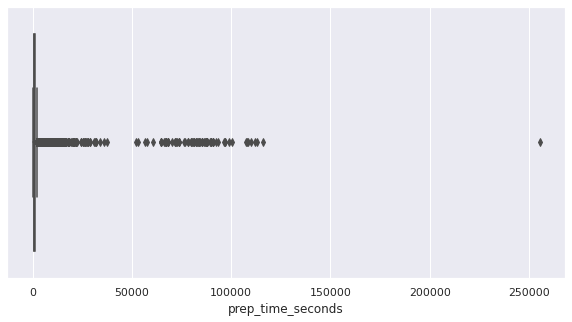

In [ ]:
sns.set(rc={'figure.figsize':(10,5)})
sns.boxplot(order['prep_time_seconds'])
plt.show()

Considering that the pre_orders do not affect preparation time of restaurants, and also those orders just take up 0.02%.
So we only consider the orders processed within a day.

In [ ]:
#check if there are pre_orders for next day
diff= pd.to_datetime(order['ord_ready_date'],utc = True) - pd.to_datetime(order['ord_ack_date'], utc = True)
order['diff'] = pd.DataFrame(diff)
order['diff'] = pd.DataFrame(diff)
order['diff'] = order['diff'].astype(int)

#drop pre_orders
# order.drop(order[order['diff'] !=0].index, inplace = True)
# order.reset_index()
# order.drop('diff', axis = 1)

ord = order[order['diff'] ==0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



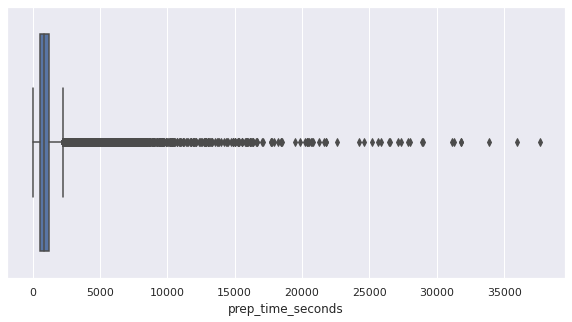

In [ ]:
sns.set(rc={'figure.figsize':(10,5)})
sns.boxplot(ord['prep_time_seconds'])
plt.show()

In [ ]:
#overall trend 
pre_overall = ord[['prep_time_seconds','ord_ack_date']].groupby('ord_ack_date').mean().reset_index()

In [ ]:
fig = go.Figure(data=go.Scatter(x=pre_overall['ord_ack_date'], 
                                y=pre_overall['prep_time_seconds'],
                                marker_color='red', text="pre_times"))
fig.show()

In [ ]:
#trend by days

pre_day = ord[['prep_time_seconds','week_day','order_value_gbp']].groupby('week_day').agg({'prep_time_seconds': 'mean','order_value_gbp':'mean'}).reset_index()

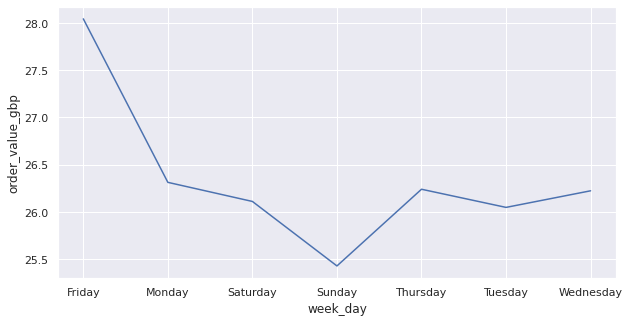

In [ ]:
plt.figure(figsize = (10,5))
# for i in ['prep_time_seconds','order_value_gbp']:
sns.lineplot(data=pre_day, x = pre_day['week_day'], y= pre_day['order_value_gbp'], palette='rocket')
#   fig = go.Figure(data=go.Scatter(x=pre_day['week_day'], 
#                                 y=pre_day[i],
#                                 marker_color='red', text="pre_times"))
plt.show()

#barplot
#in order (Sunday-> Monday...)

#why it's higher during weekday

In [ ]:
# max(order['ord_ack_date']).weekday()
# min(order['ord_ack_date'])

2

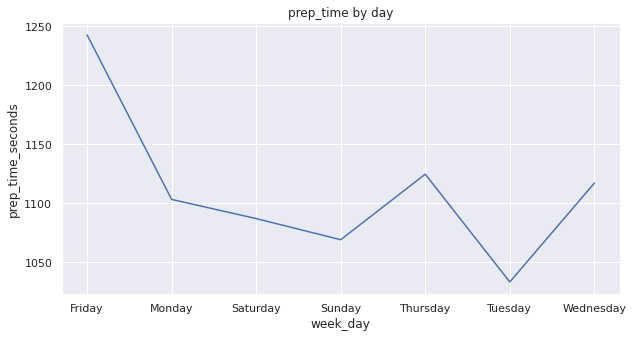

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(data=pre_day, x = pre_day['week_day'], y= pre_day['prep_time_seconds'], palette='rocket')
plt.title('prep_time by day')
plt.show()

Correlation Matrix

I take *order_value_gbp, number_of_items, prep_time_seconds into account.*

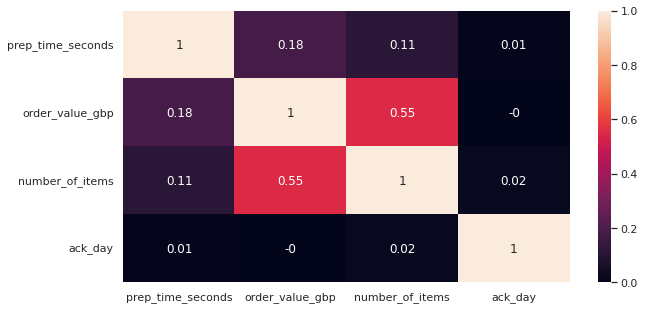

In [ ]:
#pearson --> linearity, spearman --> monotonic relationship
cor_matrix = ord[['prep_time_seconds','order_value_gbp','number_of_items','ack_day']].corr('pearson').round(2)
sns.heatmap(data = cor_matrix,annot = True)

In [ ]:
#order.corr('pearson')['prep_time_seconds'].loc['ack_day'] #pearson --> linearity, spearman --> monotonic relationship

0.005318490738610632

In [ ]:
ord.corr('pearson')['prep_time_seconds'].loc['restaurant_id']

0.00010429844075675933

###One-hot encoding

In [ ]:
#merge
ord_merged = ord.merge(restaurant[['type_of_food','city','restaurant_id']], how='left')
ord_merged_selected = ord_merged.loc[:, ~ ord_merged.columns.isin(['order_acknowledged_at','order_ready_at','ord_ready_time','ord_ack_time','diff','ack_day','ord_ack_date','ord_ready_date'])]

In [ ]:
ord_selected_dummies = pd.get_dummies(ord_merged_selected)

In [ ]:
ord_selected_dummies

,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds,week_day_Friday,week_day_Monday,week_day_Saturday,week_day_Sunday,week_day_Thursday,week_day_Tuesday,week_day_Wednesday,type_of_food_american,type_of_food_american / brunch,type_of_food_argentinian,type_of_food_asian fusion,type_of_food_australian,type_of_food_austrian,type_of_food_bagels,type_of_food_bakery,type_of_food_bbq,type_of_food_bistro,type_of_food_brazilian,type_of_food_british,type_of_food_burgers,type_of_food_burritos,type_of_food_caribbean,type_of_food_chicken,type_of_food_chinese,type_of_food_creole,type_of_food_creperie,type_of_food_deli,type_of_food_delicatessen,type_of_food_dessert,type_of_food_diner,type_of_food_ethiopian,type_of_food_european,type_of_food_fish and chips,type_of_food_french,type_of_food_french lebanese,type_of_food_georgian,...,type_of_food_scottish,type_of_food_seafood,type_of_food_sichuan chinese,type_of_food_soup,type_of_food_south african,type_of_food_south american,type_of_food_south indian,type_of_food_spanish,type_of_food_spanish tapas,type_of_food_steakhouse,type_of_food_sushi,type_of_food_sweet treats,type_of_food_taiwanese,type_of_food_thai,type_of_food_thaï / brunch,type_of_food_turkish,type_of_food_vegan,type_of_food_vietnamese,city_Berlin,city_Birmingham,city_Brighton,city_Bristol,city_Cambridge,city_Cardiff,city_Cheltenham,city_Dublin,city_Edinburgh,city_Glasgow,city_Guildford,city_Leeds,city_Leicester,city_Liverpool,city_London,city_Manchester,city_München,city_Nottingham,city_Oxford,city_Paris,city_Reading,city_Southampton
0,59.90000,1326,2,6220,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,24.00000,1326,8,603,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,15.25000,1326,3,443,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,28.05000,1326,8,669,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,56.30000,255,7,3314,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32315,35.15000,3185,4,913,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
32316,9.15771,3556,3,201,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32317,18.20000,3517,3,863,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32318,21.50000,1705,3,1339,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


### Modelling

In [ ]:
#train_test_split
X = ord_selected_dummies.loc[:,~ord_selected_dummies.columns.isin(["prep_time_seconds",'ord_ack_date','ord_ready_date'])]
y= ord_selected_dummies['prep_time_seconds']

X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.3,shuffle= True)

In [ ]:
rf = RandomForestRegressor()
model = rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)

In [ ]:
#Evaluate
mae = metrics.mean_absolute_error(y_test, y_predict)
mse = metrics.mean_squared_error(y_test, y_predict)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_predict))
r2 = metrics.r2_score(y_test, y_predict)

print('MAE (Mean-Absolute-Error): %s' %mae)
print('MSE (Mean-Squared-Error): %s' %mse)
print('RMSE (Root-MSE): %s' %rmse)
print('R2 score: %s' %r2)


MAE (Mean-Absolute-Error): 696.0986363633015
MSE (Mean-Squared-Error): 2395052.9831348797
RMSE (Root-MSE): 1547.5958720334193
R2 score: -0.07182296054712611


In [ ]:
#Using cross-validation
kf= KFold(n_splits = 5, shuffle = True, random_state = 27)
random_forest = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=20, min_samples_split=2)
cv_score = cross_val_score(random_forest, X_train, y_train, scoring='r2', cv=kf)
cv_score

array([-0.06073019, -0.045454  , -0.01012607, -0.07885548, -0.01567793])

In [ ]:
random_forest.fit(X_train, y_train)
predi= random_forest.predict(X_test)
mae = metrics.mean_absolute_error(y_test, predi)
mse = metrics.mean_squared_error(y_test, predi)
rmse = np.sqrt(metrics.mean_squared_error(y_test, predi))
r2 = metrics.r2_score(y_test, predi)

print('MAE (Mean-Absolute-Error): %s' %mae)
print('MSE (Mean-Squared-Error): %s' %mse)
print('RMSE (Root-MSE): %s' %rmse)
print('R2 score: %s' %r2)

MAE (Mean-Absolute-Error): 664.7633609753899
MSE (Mean-Squared-Error): 2111398.6157837207
RMSE (Root-MSE): 1453.0652482885002
R2 score: -0.049243809570272745


In [ ]:
error2 = pd.DataFrame({'Actual-Values': np.array(y_test).flatten(), 'Predicted-Values': predi.flatten()})

In [ ]:
error2.head(10)

,Actual-Values,Predicted-Values
0,529,958.934374
1,2479,308.213872
2,1916,894.053962
3,1157,987.333148
4,910,994.722235
5,439,976.823867
6,4997,1115.905949
7,565,949.709052
8,1476,2287.398382
9,801,1059.030191


In [ ]:
#Train model with scaling
#SCALING FEATURE:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
#train_test_split
X = ord_selected_dummies.loc[:,~ord_selected_dummies.columns.isin(["prep_time_seconds"])]
y= ord_selected_dummies['prep_time_seconds']

df = pd.DataFrame(scaler.fit_transform(X))

X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.3,shuffle= True)

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115
0,2.851852,0.097133,-0.5,7.650142,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.192593,0.097133,2.5,-0.305949,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.455556,0.097133,0.0,-0.532578,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.492593,0.097133,2.5,-0.212465,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.585185,-0.529549,2.0,3.533994,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
kf= KFold(n_splits = 5, shuffle = True, random_state = 27)
random_forest = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=20, min_samples_split=2)
cv_score = cross_val_score(random_forest, X_train, y_train, scoring='r2', cv=kf)
cv_score

array([-0.0209017 , -0.07528681, -0.07066732, -0.04157089, -0.03210499])

In [ ]:
random_forest.fit(X_train, y_train)
predi= random_forest.predict(X_test)
mae = metrics.mean_absolute_error(y_test, predi)
mse = metrics.mean_squared_error(y_test, predi)
rmse = np.sqrt(metrics.mean_squared_error(y_test, predi))
r2 = metrics.r2_score(y_test, predi)

print('MAE (Mean-Absolute-Error): %s' %mae)
print('MSE (Mean-Squared-Error): %s' %mse)
print('RMSE (Root-MSE): %s' %rmse)
print('R2 score: %s' %r2)

MAE (Mean-Absolute-Error): 671.2496571071515
MSE (Mean-Squared-Error): 2104863.390928735
RMSE (Root-MSE): 1450.8147334958846
R2 score: -0.04516916090460832
